In [16]:
#!/usr/bin/python3 
import pandas as pd  # dataframe Series等的操作
import numpy as np  # 一些函数，如log等    
from fbprophet import Prophet  # facebook prophet 框架对象
from sklearn.metrics import mean_squared_error  # 均值方差错误检测函数 sklearn包中有很多其他函数
from fbprophet.diagnostics import cross_validation  # 交叉验证函数
import matplotlib.pyplot as plt # Python 的 2D绘图库
import math  # 
#?plt.hist()查看帮助

In [17]:
df2014 = pd.read_csv('data/sales/90067660_Top Line Metrics_Default View_20141231.csv')
# print(type(df))  #<class 'pandas.core.frame.DataFrame'>
df2015 = pd.read_csv('data/sales/90067660_Top Line Metrics_Default View_20151231.csv')
df2016 = pd.read_csv('data/sales/90067660_Top Line Metrics_Default View_20161231.csv')
df2017 = pd.read_csv('data/sales/90067660_Top Line Metrics_Default View_20171231.csv')

df_2years = pd.concat([df2014, df2015])
df_3years = pd.concat([df2014, df2015, df2016])
df_4years = pd.concat([df2014, df2015, df2016, df2017])

dflist = [df2014, df_2years, df_3years, df_4years]
# print(type(dflist))  #<class 'list'>
for i in range(len(dflist)):
    #dflist[i] = dflist[i][dflist[i].columns[0:2]]
    '''
    这个loc的用法是对行、对列的一种筛选。 
    大多数情况下的应用场景是用数字取行，用str取列。 
    比如loc[0:3,[“a”,”b”]]。取0到第3行（左闭右开，非整型值时左闭右闭），”a”列与”b”列。
    '''
    dflist[i] = dflist[i].loc[:,('Date', 'Sales')]
    #对列重命名
    dflist[i].columns = ['ds', 'y']
    #去除$
    dflist[i].y = dflist[i].y.str.replace("$","")
    # print(type(df.y)) <class 'pandas.core.series.Series'>
    # print(df.y.str) <pandas.core.strings.StringMethods object at 0x7f92751deb70>
    #str 转float
    dflist[i].y = dflist[i].y.astype(float)
    # 取指数，达成正态分布？
    dflist[i]['y'] = np.log(dflist[i]['y'])
    #df['cap'] = 20 #logistic 模型时可以设置上限cap

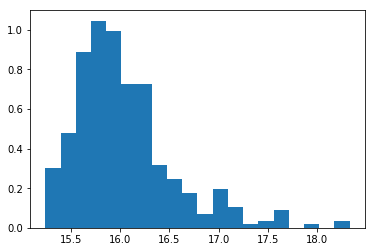

In [18]:
# plt.hist直方图
# bin指定(箱子)的个数,也就是总共有几条条状图, density=true 标准化 积分（直方图下的面积）为1
plt.hist(dflist[0].y, bins=20, density=True)
plt.show()

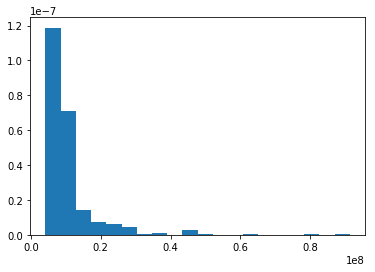

In [19]:
# 查看重新e次方之后原始数据的直方图
# pandas的map方法可以简而言之这样解释:对dataframe的每个元素执行func函数,用法基本如下:df.map(func),输入的应该是一个函数
plt.hist(dflist[0].y.map(lambda x: math.exp(x)), bins=20, density=True)
plt.show()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.5/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabl

        mape        mse            time_period
0   0.046299   1.318288            2014+yearly
1   0.046299   1.318287    2014+yearly&holiday
2   0.025924   0.863710           2014+default
3   0.010891   0.083914          2years+yearly
4   0.016577   0.135454  2years+yearly&holiday
5   0.203011  11.153033         2years+default
6   0.010816   0.094358          3years+yearly
7   0.010671   0.086881  3years+yearly&holiday
8   0.010816   0.094358         3years+default
9   0.012107   0.091084          4years+yearly
10  0.011026   0.079932  4years+yearly&holiday
11  0.012107   0.091084         4years+default


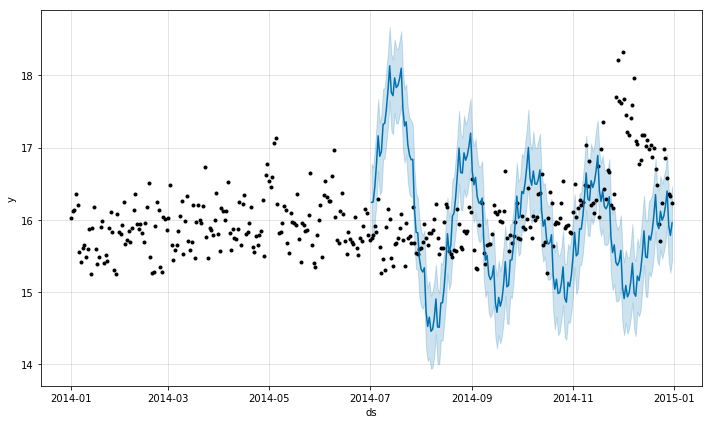

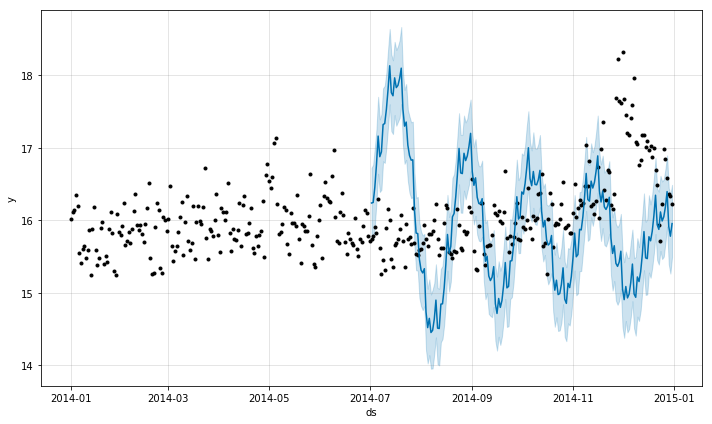

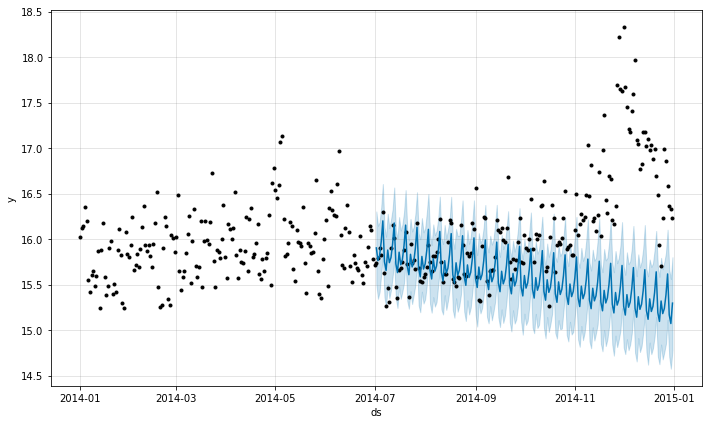

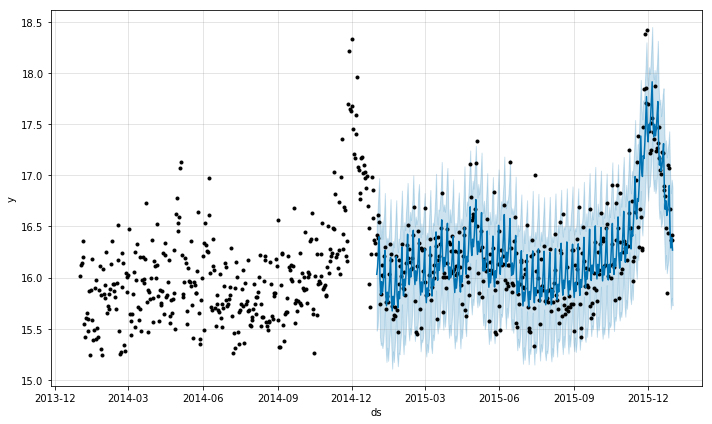

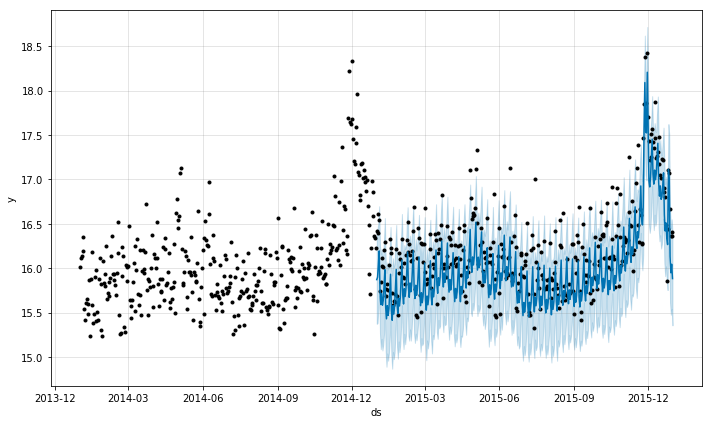

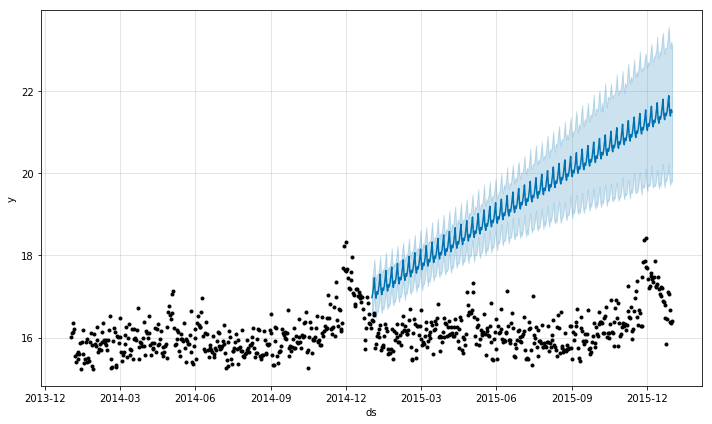

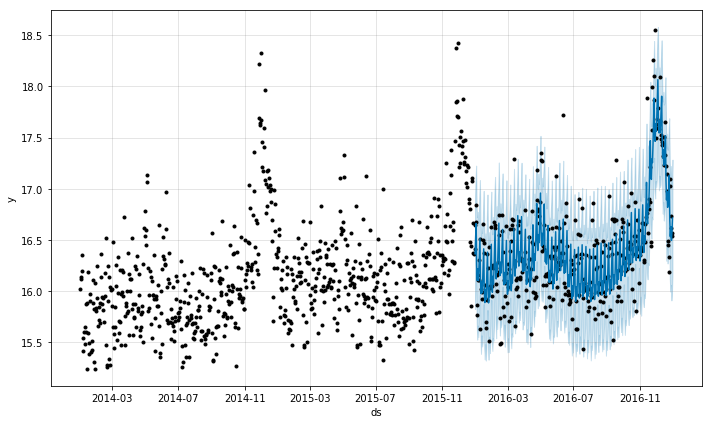

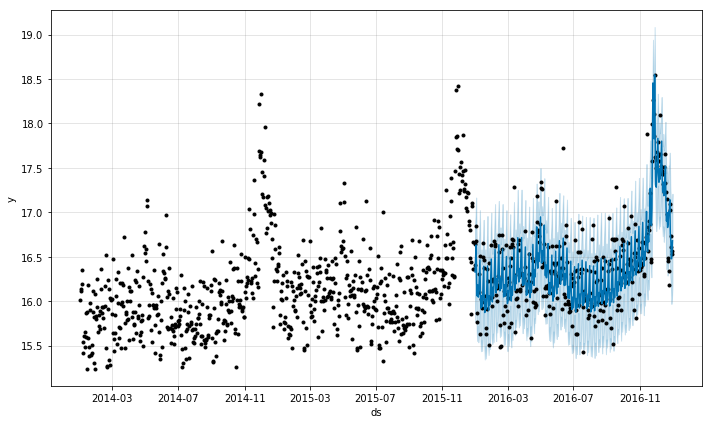

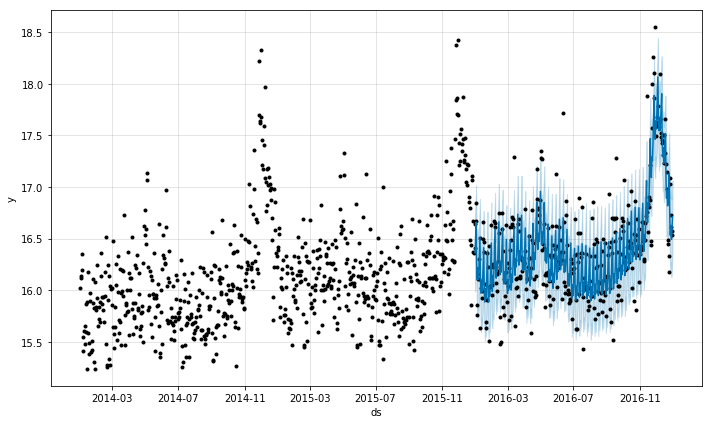

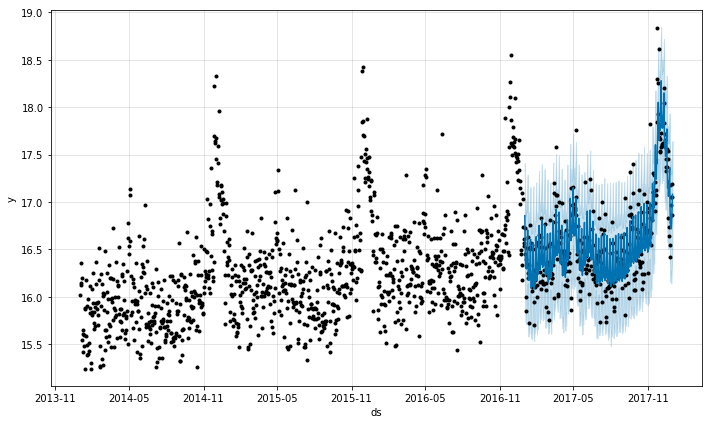

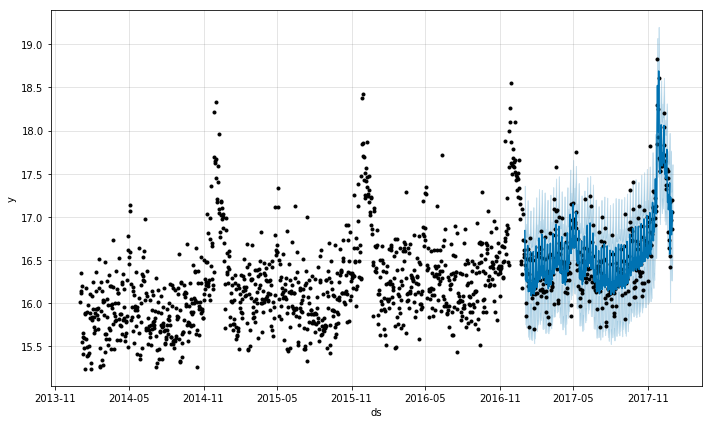

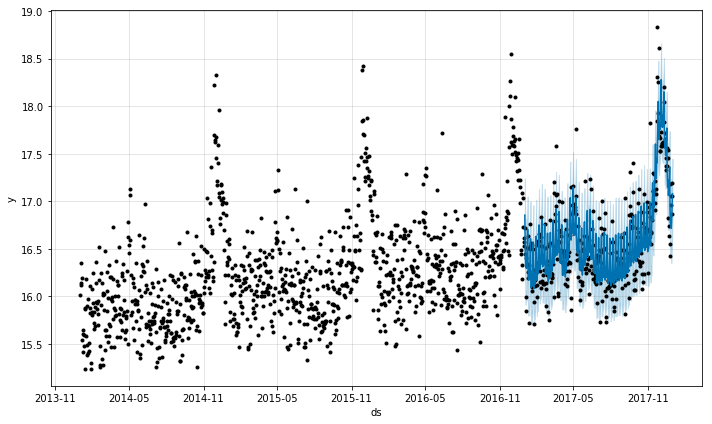

In [20]:
christmas = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2014-12-25', '2015-12-25', '2016-12-25', '2017-12-25']),
  'lower_window': 0,
  'upper_window': 3,
})
thanksgiving = pd.DataFrame({
  'holiday': 'thanksgiving',
  'ds': pd.to_datetime(['2014-11-27', '2015-11-26', '2016-11-24', '2017-11-23']),
  'lower_window': 0,
  'upper_window': 5,
})

holidays = pd.concat((christmas, thanksgiving))

validation_args0= ['183 days', '182 days', '0 days']
validation_args1= ['365 days', '365 days', '0 days']
validation_args2= ['366 days', '730 days', '0 days']
validation_args3= ['365 days', '1096 days', '0 days']
vlist = [validation_args0, validation_args1, validation_args2, validation_args3]

cast_number = [182, 365, 730, 1096]
result_list = []
years = ['2014', '2years', '3years', '4years']
models = ['yearly', 'yearly&holiday', 'default']

for i in range(len(dflist)):
    m_default = Prophet()
    # mcmc_samples = 200
    m = Prophet(changepoint_prior_scale=0.05, yearly_seasonality=True,
               holidays_prior_scale=0.95, interval_width=0.95)
    # mcmc_samples = 200
    m_with_holiday = Prophet(changepoint_prior_scale=0.05, yearly_seasonality=True,
               holidays_prior_scale=0.95, interval_width=0.95, holidays = holidays)
    # m_default放到list的第一个就报错。。。
    mlist = [m, m_with_holiday, m_default]
    for j in range(len(mlist)):
        mlist[j].fit(dflist[i])
        # period一定为准确的年份倍数，若三个参数均为年份
        df_cv = cross_validation(mlist[j], horizon = vlist[i][0], period = vlist[i][1], initial= vlist[i][2])
        mse = mean_squared_error(dflist[i].y[cast_number[i]:], df_cv.yhat)
        # 如果不用Series,values方法， 剪裁过的series序号不同将无法相减！用这个方法会将其变成一个纯数组
        mape = np.median(np.true_divide(np.abs(df_cv.yhat.values - (dflist[i].y[cast_number[i]:].values)), dflist[i].y[cast_number[i]:].values))
        result = dict()
        result['time_period'] = years[i] + '+' + models[j]
        result['mse'] = mse
        result['mape'] = mape
        result_list.append(result)
        m.plot(df_cv);

print(pd.DataFrame(result_list))

'''
结论： 一年数据加holiday反而不好，年份多了之后加holiday好一些
      不到一年的数据时，一定不能加yearly，以年为单位，就要加上
'''

In [22]:
future = m_with_holiday.make_future_dataframe(periods=730)
#future['cap'] = 20
future.tail()

,ds
2186,2019-12-27
2187,2019-12-28
2188,2019-12-29
2189,2019-12-30
2190,2019-12-31


In [24]:
forecast = m_with_holiday.predict(future)
print(type(forecast))
#forecast.tail()
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast[(forecast['christmas'] + forecast['thanksgiving']).abs() > 0][['ds', 'christmas', 'thanksgiving']][-10:]

<class 'pandas.core.frame.DataFrame'>


,ds,christmas,thanksgiving
1422,2017-11-23,0.000000,0.959523
1423,2017-11-24,0.000000,1.254699
1424,2017-11-25,0.000000,0.596747
1425,2017-11-26,0.000000,0.180978
1426,2017-11-27,0.000000,1.194654
1427,2017-11-28,0.000000,0.454492
1454,2017-12-25,-0.338302,0.000000
1455,2017-12-26,0.460722,0.000000
1456,2017-12-27,0.332878,0.000000
1457,2017-12-28,0.154111,0.000000


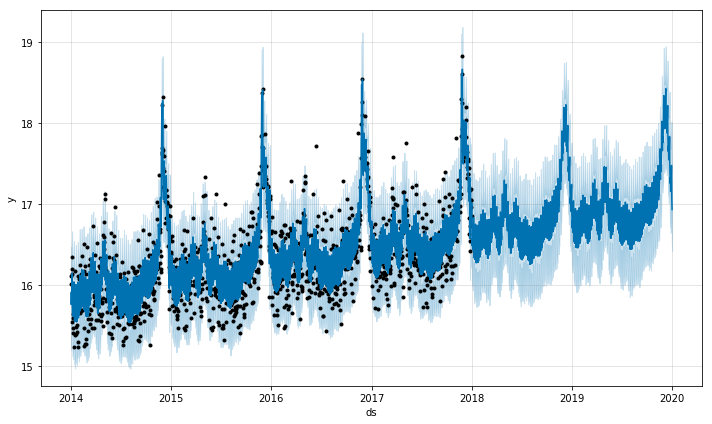

In [25]:
m_with_holiday.plot(forecast);

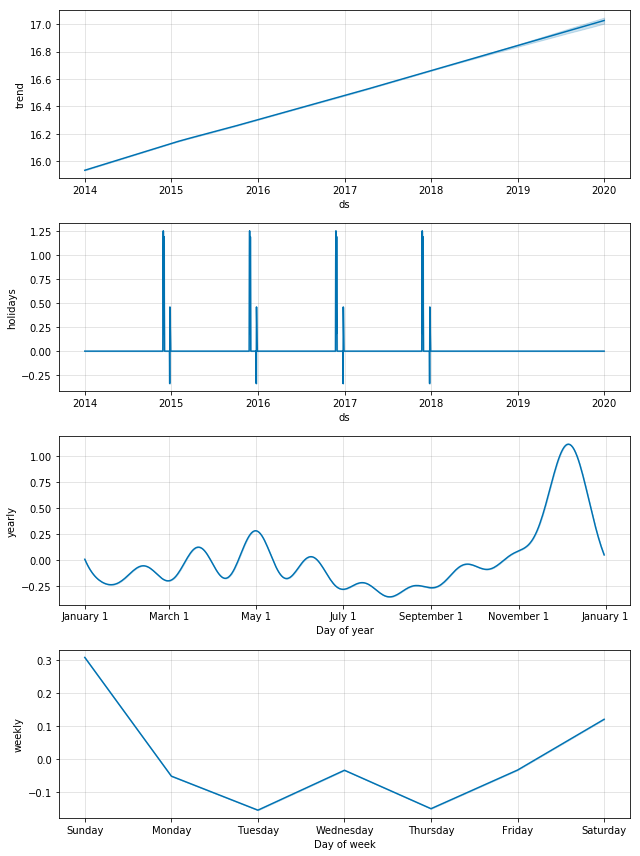

In [26]:
m_with_holiday.plot_components(forecast);

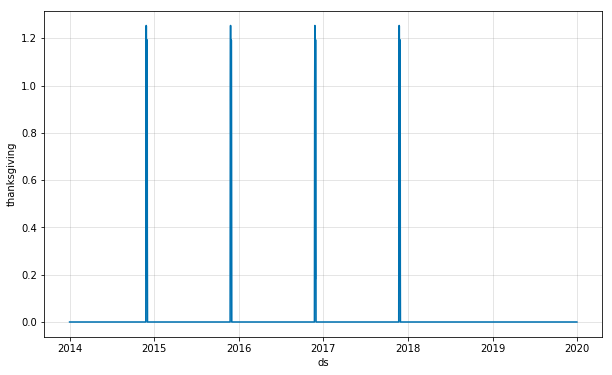

In [27]:
m_with_holiday.plot_forecast_component(forecast, 'thanksgiving')

In [29]:
m_with_holiday.predictive_samples(future)

{'seasonal': array([[-0.02133417, -0.02133417, -0.02133417, ..., -0.02133417,
         -0.02133417, -0.02133417],
        [-0.1693077 , -0.1693077 , -0.1693077 , ..., -0.1693077 ,
         -0.1693077 , -0.1693077 ],
        [-0.08044679, -0.08044679, -0.08044679, ..., -0.08044679,
         -0.08044679, -0.08044679],
        ...,
        [ 0.45370489,  0.45370489,  0.45370489, ...,  0.45370489,
          0.45370489,  0.45370489],
        [ 0.05171047,  0.05171047,  0.05171047, ...,  0.05171047,
          0.05171047,  0.05171047],
        [-0.09016548, -0.09016548, -0.09016548, ..., -0.09016548,
         -0.09016548, -0.09016548]]),
 'trend': array([[15.93300477, 15.93300477, 15.93300477, ..., 15.93300477,
         15.93300477, 15.93300477],
        [15.93354248, 15.93354248, 15.93354248, ..., 15.93354248,
         15.93354248, 15.93354248],
        [15.9340802 , 15.9340802 , 15.9340802 , ..., 15.9340802 ,
         15.9340802 , 15.9340802 ],
        ...,
        [17.05368597, 17.02640495